# Random Walks in Python

## Simulating Random Walks

We will simulate random walks on a simple graph of five nodes as follows.

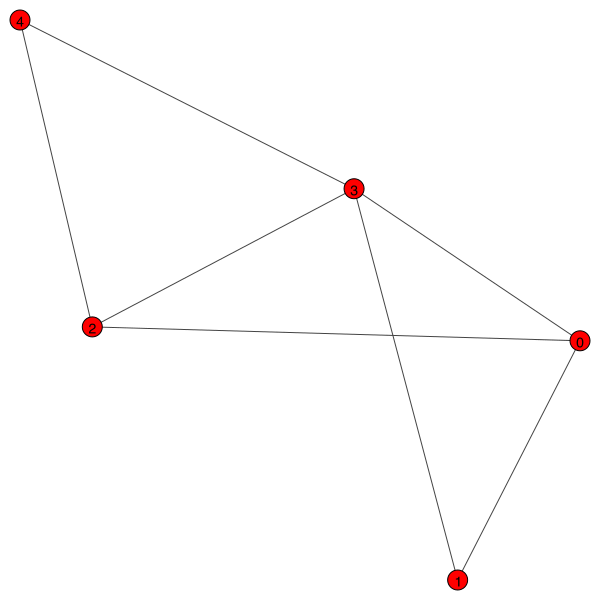

In [1]:
import numpy as np
import igraph

g = igraph.Graph()

g.add_vertices([0, 1, 2, 3, 4])
g.add_edges([(0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (2, 4), (3, 4)])
igraph.plot(g, vertex_size=20, vertex_label=g.vs["name"])

A random walk is characterized by the transition probabilities between nodes.

$$
P_{ij} = \frac{A_{ij}}{k_i}
$$

Let us first compute the transition probabilities and store them in a matrix, $\mathbf{P}$.

In [2]:
A = g.get_adjacency_sparse().toarray()
k = np.array(g.degree())
n_nodes = g.vcount()

# A simple but inefficient way to compute P
P = np.zeros((n_nodes, n_nodes))
for i in range(n_nodes):
    for j in range(n_nodes):
        if k[i] > 0:
            P[i, j] = A[i, j] / k[i]
        else:
            P[i, j] = 0

# Alternative, more efficient way to compute P
P = A / k[:, np.newaxis]

# or even more efficiently
P = np.einsum("ij,i->ij", A, 1 / k)

In [3]:
print("Transition probability matrix:\n", P)

Transition probability matrix:
 [[0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.33333333 0.         0.         0.33333333 0.33333333]
 [0.25       0.25       0.25       0.         0.25      ]
 [0.         0.         0.5        0.5        0.        ]]


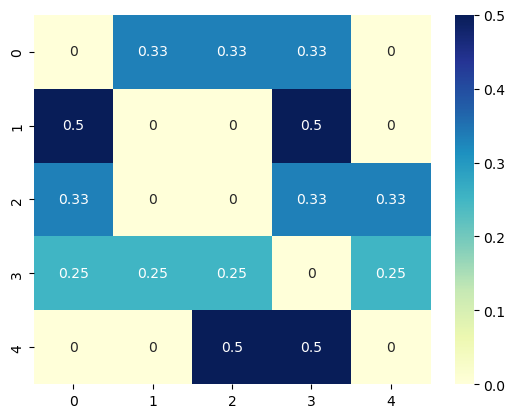

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(P, annot=True, cmap="YlGnBu")
plt.show()

Each row and column of $\mathbf{P}$ corresponds to a node, with entries representing the transition probabilities from the row node to the column node.

Now, let us simulate a random walk on this graph. We represent a position of the walker by a vector, $\mathbf{x}$, with five elements, each of which represents a node. We mark the node that the walker is currently at by `1` and others as `0`.

In [5]:
x = np.array([0, 0, 0, 0, 0])
x[0] = 1
print("Initial position of the walker:\n", x)

Initial position of the walker:
 [1 0 0 0 0]


This vector representation is convenient to get the probabilities of transitions to other nodes from the current node:

$$
\mathbf{x} \mathbf{P}
$$

which is translated into the following code:

In [6]:
probs = x @ P
print("Position of the walker after one step:\n", probs)

Position of the walker after one step:
 [0.         0.33333333 0.33333333 0.33333333 0.        ]


We can then draw the next node based on the probabilities

In [7]:
next_node = np.random.choice(n_nodes, p=probs)
x[:] = 0 # zero out the vector
x[next_node] = 1 # set the next node to 1
print("Position of the walker after one step:\n", x)

Position of the walker after one step:
 [0 0 0 1 0]


By repeating this process, we can simulate the random walk.

### Exercise 01

Write the following function to simulate the random walk for a given number of steps and return the $x$ for each step.

In [8]:
def random_walk(A, n_steps):
    """
    Simulate the random walk on a graph with adjacency matrix A.

    Args:
        A (np.ndarray): The adjacency matrix of the graph.
        x (np.ndarray): The initial position of the walker.
        n_steps (int): The number of steps to simulate.

    Returns:
        np.ndarray: The position of the walker after each step.
    """
    # Your code here
    pass

## Expected behavior of random walks

What is the expected position of the walker after multiple steps? It is easy to compute the expected position of the walker after one step from initial position $x(0)$:

$$
\mathbb{E}[x(1)] = x(0) P
$$

where $x(t)$ is the probability distribution of the walker at time $t$. In Python, the expected position of the walker at time $t=1$ is given by

In [9]:
x_0 = np.array([1, 0, 0, 0, 0])
x_1 = x_0 @ P
print("Expected position of the walker after one step:\n", x_1)

Expected position of the walker after one step:
 [0.         0.33333333 0.33333333 0.33333333 0.        ]


For the second step, the expected position of the walker is given by

$$
\mathbb{E}[x(2)] = \mathbb{E}[x(1) P] = \mathbb{E}[x(0) P] P = x(0) P^2
$$

In other words,

In [10]:
x_2 = x_1 @ P
print("Expected position of the walker after two steps:\n", x_2)

Expected position of the walker after two steps:
 [0.36111111 0.08333333 0.08333333 0.27777778 0.19444444]


Following the same argument, the expected position of the walker at time $t$ is given by

$$
\mathbb{E}[x(t)] = x(0) P^t
$$

### Exercise 02

Write a function to compute the expected position of the walker at time $t$ using the above formula:

In [11]:
def expected_position(A, x_0, t):
    """
    Compute the expected position of the walker at time t.

    Args:
        A (np.ndarray): The adjacency matrix of the graph.
        x_0 (np.ndarray): The initial position of the walker.
        t (int): The number of steps to simulate.
    """
    # Your code here
    pass

### Exercise 03

Plot each element of $x(t)$ as a function of $t$ for $t=0,1,2,\ldots, 1000$. Try different initial positions and compare the results!

Steps:
1. Define the initial position of the walker.
2. Compute the expected position of the walker at time $t$ using the function you wrote above.
3. Draw a line for each element of $x(t)$, totalling 5 lines.
4. Create multiple such plots for different initial positions and compare them.

## Community structure

Random walks can capture community structure of a network.
To see this, let us consider a network of a ring of cliques.

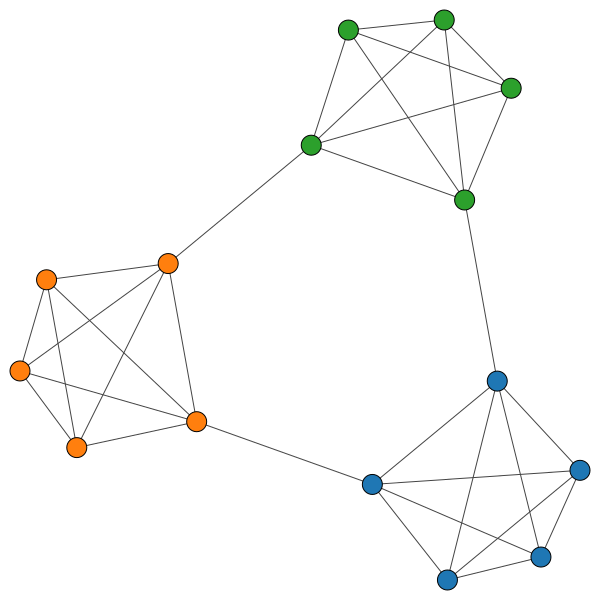

In [12]:
import networkx as nx
import igraph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

n_cliques = 3
n_nodes_per_clique = 5

G = nx.ring_of_cliques(n_cliques, n_nodes_per_clique)
g = igraph.Graph().Adjacency(nx.to_numpy_array(G).tolist()).as_undirected()
membership = np.repeat(np.arange(n_cliques), n_nodes_per_clique)

color_map = [sns.color_palette()[i] for i in membership]
igraph.plot(g, vertex_size=20, vertex_color=color_map)

Let us compute the expected position of the walker after 1 to 10 steps.

**Compute the transition matrix**:

In [13]:
from scipy import sparse

# Get the adjacency matrix and degree
A = g.get_adjacency_sparse()
k = np.array(g.degree())

# This is an efficient way to compute the transition matrix
# using scipy.sparse
P = sparse.diags(1 / k) @ A

**Compute the expected position of the walker after 1 to 300 steps**:

In [14]:
x_t = np.zeros(g.vcount())
x_t[2] = 1
x_list = [x_t]
for t in range(300):
    x_t = x_t @ P
    x_list.append(x_t)
x_list = np.array(x_list)

**Plot the expected position of the walker at each step**:

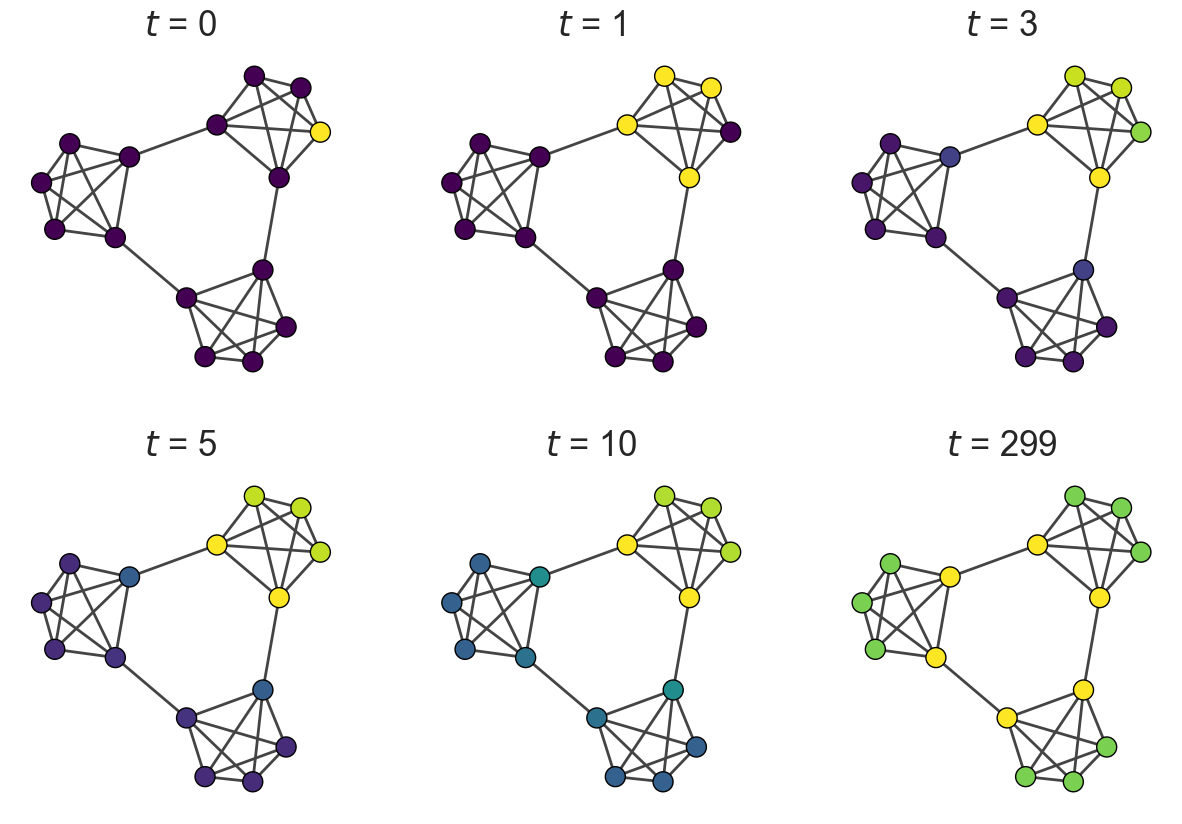

In [15]:
cmap = sns.color_palette("viridis", as_cmap=True)

sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')

fig, axes = plt.subplots(figsize=(15,10), ncols = 3, nrows = 2)

t_list = [0, 1, 3, 5, 10, 299]
for i, t in enumerate(t_list):
    igraph.plot(g, vertex_size=20, vertex_color=[cmap(x_list[t][j] / np.max(x_list[t])) for j in range(g.vcount())], target = axes[i//3][i%3])
    axes[i//3][i%3].set_title(f"$t$ = {t}", fontsize = 25)

where the color of each node represents the probability of the walker being at that node.

An important observation is that the walker spends more time in the clique that it started from and then diffuse to others. Thus, the position of the walker before reaching the steady state tells us the community structure of the network.

## Exercise 04

1. Generate a network of 100 nodes with 4 communities using a stochastic block model, with inter-community edge probability $0.05$ and intra-community edge probability $0.2$. Then, compute the expected position of the walker starting from node zero after $x$ steps. Plot the results for $x = 0, 5, 10, 1000$.

2. Increase the inter-community edge probability to $0.15$ and repeat the simulation. Compare the results with the previous simulation.